In [ ]:
import torch
import torchvision

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


# Importing the python scripts from Going Modular section

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (1234/1234), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 4056 (delta 1141), reused 1124 (delta 1124), pack-reused 2822
Receiving objects: 100% (4056/4056), 649.94 MiB | 36.41 MiB/s, done.
Resolving deltas: 100% (2386/2386), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setting-up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Getting The Data

In [ ]:
from pathlib import Path
import os
import zipfile
import requests

In [ ]:
main_path = Path('data/')
images_path = main_path / 'pizza_steak_sushi'

if images_path.is_dir():
  print(f'{images_path} already exists.')
else:
  print(f'{images_path} does not exists, creating one...')
  images_path.mkdir(parents=True, exist_ok=True)

  with open(main_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading the pizza_steak_sushi.zip file')
    f.write(request.content)

  with zipfile.ZipFile(main_path / 'pizza_steak_sushi.zip', 'r') as zip_file:
    print('Unzipping the pizza_steak_sushi zip file')
    zip_file.extractall(images_path)

  os.remove(main_path / 'pizza_steak_sushi.zip')

data/pizza_steak_sushi does not exists, creating one...
Unzipping the pizza_steak_sushi zip file


In [ ]:
train_dir = images_path / 'train'
test_dir = images_path / 'test'

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Creating Datasets and DataLoaders

In [ ]:
# When using a model from transfer learning, we need our data to be similar to the data that the model was trained on (similar transforms)
# We can create this transform manually (By referring to the documentation)
# The images needs to be of size at least 224x224, the tensor values need to be between 0 and 1, and the data needs to normalized (have a certain distribution)
from torchvision import transforms

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size = (224,224), antialias=True),
    transforms.ToTensor(),
    normalize
])

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)

In [ ]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e1520818f70>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# This transform can be created automatically by leveraging the weights of some pretrained model
# We'll be using the weights from EfficientNetB0 that was trained on ImageNetK1
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT means the best avaiable weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Now to create the transform
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transform,
                                                                               batch_size = 32)

In [ ]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e1446063280>,
 ['pizza', 'steak', 'sushi'])

# Picking A Model

- In orde to pick a model we need to consider how fast it needs to perform, its size and its performance.
- All of these are application dependant.
- In our case we want to deploy the model that is trained on FoodVision Mini to mobile devices.
- Hence we need a model that is relatively small while still having a good performance and speed.

In [ ]:
# THERE COULD BE A BUG IN THE 0.16 VERSION OF TORCHVISION SO USE THIS CODE INSTEAD TO CREATE THE EFFICIENTNETB0 MODEL
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

In [ ]:
# Creating the EfficientNetB0 model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# EfficientNetB0 architecture is split into 3 blocks
# The first is where the model extracts features from our model
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
# The second is a pooling layer (avgpool) that compresses all the found features into a single vector of length 1280
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
# And finally the output classification layer that classifies the images.
# This layer will be customized to match the needs of our application.
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

- Getting a summary of our model with torchinfo

In [ ]:
from torchinfo import summary

summary = summary(model = model,
                  input_size = (1,3,224,224),
                  col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
                  col_width = 20,
                  row_settings = ['var_names'])

summary

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

# Creating The Feature Extraction Model

In [ ]:
# This is done be freezing the base layers (feature layers) and updating the output head (classifier layer)

# 1. First we'll freeze the base layers by turning off gradient tracking
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
# Now the feature layers are not trainable which leaves the classifier head parameters which we will modify to suit our application

# 2. Updating the classifier head
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace=True),
    nn.Linear(in_features = 1280, out_features = len(class_names))
).to(device)

# Model Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [ ]:
from going_modular.going_modular import engine
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

end_time = timer()
print(f'[INFO] Training time = {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Training time = 13.366 seconds


In [ ]:
results

{'train_loss': [1.0924270376563072,
  0.8716965243220329,
  0.7647949755191803,
  0.7108824998140335,
  0.6254764012992382],
 'train_acc': [0.3984375, 0.77734375, 0.79296875, 0.75390625, 0.78515625],
 'test_loss': [0.9132681488990784,
  0.791197657585144,
  0.7463406125704447,
  0.6373109022776285,
  0.6261006593704224],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061]}

# Plotting Loss Curves

[INFO] Could not find helper_functions.py, downloading...


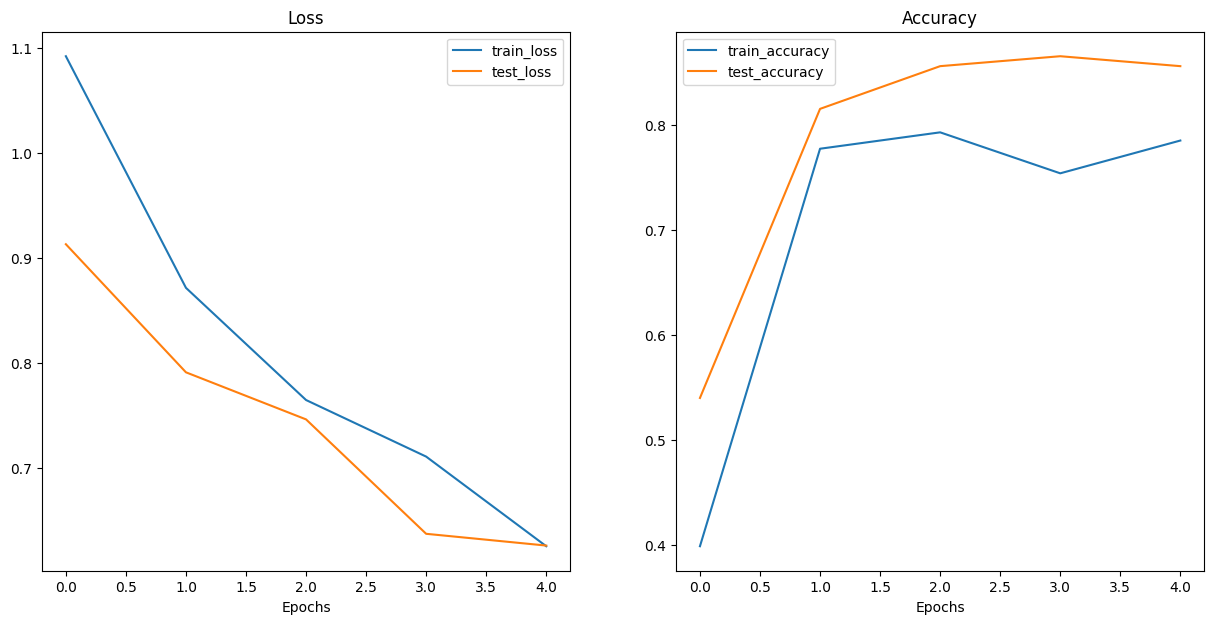

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f'[INFO] Could not find helper_functions.py, downloading...')
  with open('helper_functions.py', 'wb') as f:
    import requests
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

# Creating a Function to Predict The Class of Custom Images

In [ ]:
from typing import List, Tuple
import PIL

def pred_and_plot(model:torch.nn.Module,
                  class_names:List[str],
                  image_path:str,
                  image_size:Tuple[int,int],
                  transform:torchvision.transforms = None,
                  device:torch.device = device):

  custom_image = PIL.Image.open(image_path)

  if transform is not None:
    image_transform = transform
  else:
    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])
    image_transform = transforms.Compose([
    transforms.Resize(size = image_size, antialias=True),
    transforms.ToTensor(),
    normalize
    ])

  transformed_image = image_transform(custom_image)
  transformed_image_batched = transformed_image.unsqueeze(0)

  if device:
    model.to(device)

  model.eval()
  with torch.inference_mode():
    y_logits = model(transformed_image_batched.to(device))

  y_preds = torch.softmax(y_logits, dim = 1)
  y_labels = y_preds.argmax(dim = 1)

  plt.figure()
  plt.imshow(custom_image)
  plt.axis(False)
  title = f'Pred. Class: {class_names[y_labels]} | Pred. Probability: {y_preds.max():.3f}'
  plt.title(title)

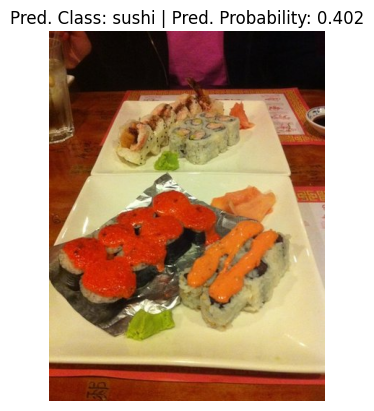

In [ ]:
pred_and_plot(model = model,
              class_names = class_names,
              image_path = '/content/data/pizza_steak_sushi/test/sushi/207578.jpg',
              image_size = [224,224],
              transform=None,
              device = device)

# Making Predictions on a List of Random Images

In [ ]:
import random
random_images = random.sample(list(test_dir.glob('*/*.jpg')), k = 3)

In [ ]:
random_images

[PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg')]

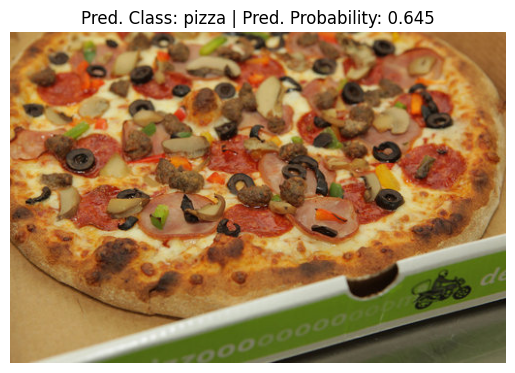

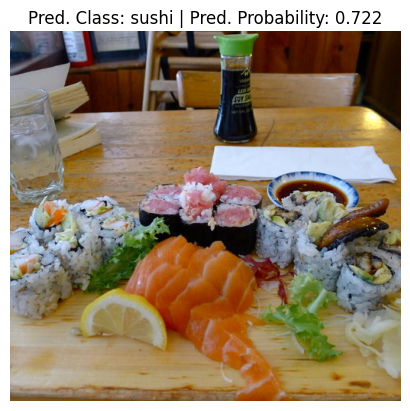

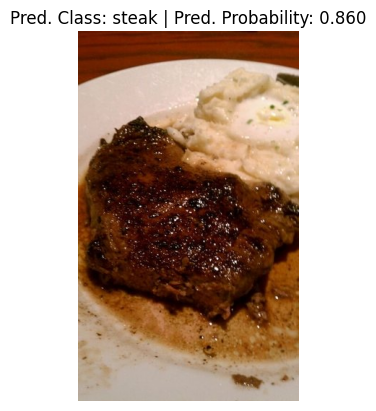

In [ ]:
for image_path in random_images:
  pred_and_plot(model = model,
                image_path = image_path,
                class_names = class_names,
                image_size = (224,224),
                device = device)

In [ ]:
image_path = main_path / 'custom_downloaded_img.jpg'
with open(main_path / 'custom_downloaded_img.jpg', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/0fa794be523a10b409a2061e43ae03c419d5ace7/data/04-pizza-dad.jpeg')
  f.write(request.content)

In [ ]:
image_path

PosixPath('data/custom_downloaded_img.jpg')

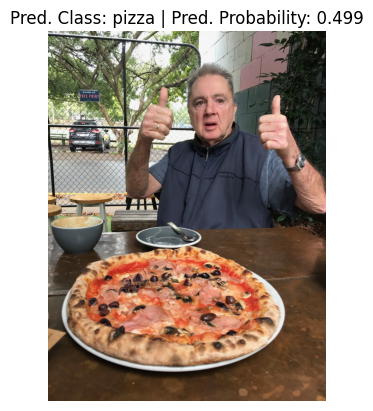

In [ ]:
pred_and_plot(model = model,
              class_names = class_names,
              image_path = image_path,
              image_size = (224,224),
              device = device)

# Making Predictions on the test data and plotting the Confusion Matrix

In [ ]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_probs = []
test_preds = []

model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)

    test_logits = model(X)

    pred_probs = torch.softmax(test_logits, dim=1)
    test_probs.append(pred_probs)

    pred_labels = torch.argmax(pred_probs, dim=1)

    test_preds.append(pred_labels)

test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [ ]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [ ]:
# Importing neccessary libraries to calculate and plot a confusion matrix
try:
  from torchmetrics import ConfusionMatrix
  import mlxtend
except:
  !pip install -q torchmetrics
  !pip install -q mlxtend
  from torchmetrics import ConfusionMatrix
  import mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 6.7 MB/s eta 0:00:00


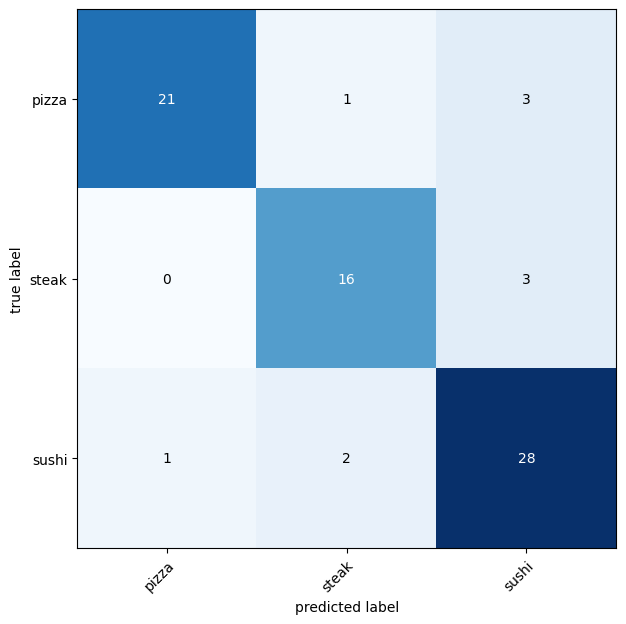

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

# Finding the wrongest predictions and plotting them

In [ ]:
test_data_path = list(test_dir.glob('*/*.jpg'))
test_pred_list = []
for img_path in tqdm(test_data_path):
  test_img_info = {}
  test_img_info['img_path'] = str(img_path)
  img_class = img_path.parent.stem
  test_img_info['img_class'] = img_class

  img = PIL.Image.open(img_path)
  transformed_img = auto_transform(img).unsqueeze(0)
  model.eval()
  with torch.inference_mode():
    y_logits = model(transformed_img.to(device))
    y_preds = torch.softmax(y_logits, dim = 1)
    y_label = y_preds.argmax(dim = 1)
    y_class = class_names[y_label]

    test_img_info['pred_class'] = y_class
    test_img_info['pred_prob'] = y_preds.max().cpu().item()
    test_img_info['correct'] = img_class == y_class


  test_pred_list.append(test_img_info)

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
pred_df = pd.DataFrame(test_pred_list)
pred_df

,img_path,img_class,pred_class,pred_prob,correct
0,data/pizza_steak_sushi/test/pizza/1925494.jpg,pizza,pizza,0.590362,True
1,data/pizza_steak_sushi/test/pizza/3475871.jpg,pizza,pizza,0.572594,True
2,data/pizza_steak_sushi/test/pizza/930553.jpg,pizza,pizza,0.674808,True
3,data/pizza_steak_sushi/test/pizza/1503858.jpg,pizza,pizza,0.532969,True
4,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,sushi,0.559406,False
...,...,...,...,...,...
70,data/pizza_steak_sushi/test/steak/690177.jpg,steak,steak,0.819205,True
71,data/pizza_steak_sushi/test/steak/296375.jpg,steak,steak,0.850166,True
72,data/pizza_steak_sushi/test/steak/894825.jpg,steak,steak,0.748636,True
73,data/pizza_steak_sushi/test/steak/27415.jpg,steak,sushi,0.387377,False


In [ ]:
top_five_wrong_preds = pred_df.sort_values(by=['correct','pred_prob'], ascending = [True, False]).head()
top_five_wrong_preds

,img_path,img_class,pred_class,pred_prob,correct
4,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,sushi,0.559406,False
11,data/pizza_steak_sushi/test/pizza/2871261.jpg,pizza,steak,0.508551,False
57,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,sushi,0.489857,False
7,data/pizza_steak_sushi/test/pizza/344397.jpg,pizza,sushi,0.477214,False
35,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,steak,0.431213,False


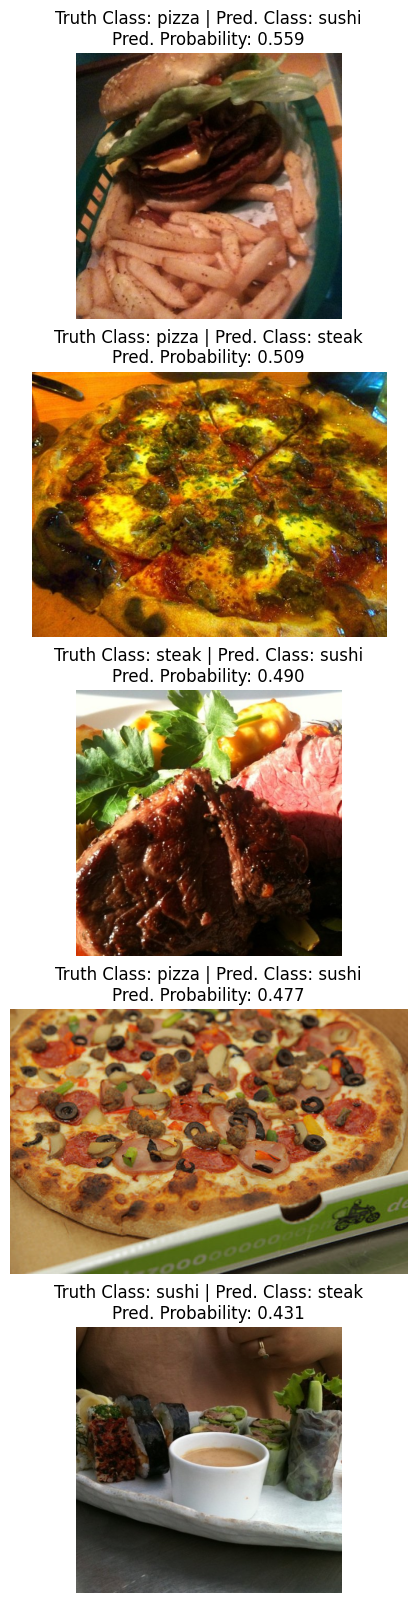

In [ ]:
plt.figure(figsize = (9,20))
for i, (img_path, img_class, pred_class, pred_prob) in enumerate(zip(
    top_five_wrong_preds['img_path'], top_five_wrong_preds['img_class'], top_five_wrong_preds['pred_class'], top_five_wrong_preds['pred_prob'])):
  plt.subplot(5, 1, i+1)
  image = torchvision.io.read_image(img_path)
  plt.imshow(image.permute(1,2,0))
  plt.axis(False)
  title = f'Truth Class: {img_class} | Pred. Class: {pred_class}\nPred. Probability: {pred_prob:.3f}'
  plt.title(title)

# Training the previous model for 10 epochs and comparing the results

In [ ]:
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

for param in model_1.features.parameters():
  param.requires_grad = False

torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchinfo import summary
summary(model_1,
        input_size=[32, 3, 224, 224],
        col_names=["input_size", "output_size", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Trainable
EfficientNet                                            [32, 3, 224, 224]         [32, 3]                   Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv: 3-4                                 [32, 32, 112, 112]        [32

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062
[INFO] Total training time: 39.156 seconds


In [ ]:
model_1_results

{'train_loss': [1.0924270376563072,
  0.8716965243220329,
  0.7647949755191803,
  0.7108824998140335,
  0.6254764012992382,
  0.5784515738487244,
  0.5262740328907967,
  0.5226370729506016,
  0.5670521445572376,
  0.48470527306199074],
 'train_acc': [0.3984375,
  0.77734375,
  0.79296875,
  0.75390625,
  0.78515625,
  0.89453125,
  0.91015625,
  0.80078125,
  0.8125,
  0.8203125],
 'test_loss': [0.9132681488990784,
  0.791197657585144,
  0.7463406125704447,
  0.6373109022776285,
  0.6261006593704224,
  0.5743227005004883,
  0.5469824473063151,
  0.5290801127751669,
  0.5076459546883901,
  0.43997155626614887],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061,
  0.8759469696969697,
  0.8759469696969697,
  0.8664772727272728,
  0.8456439393939394,
  0.90625]}

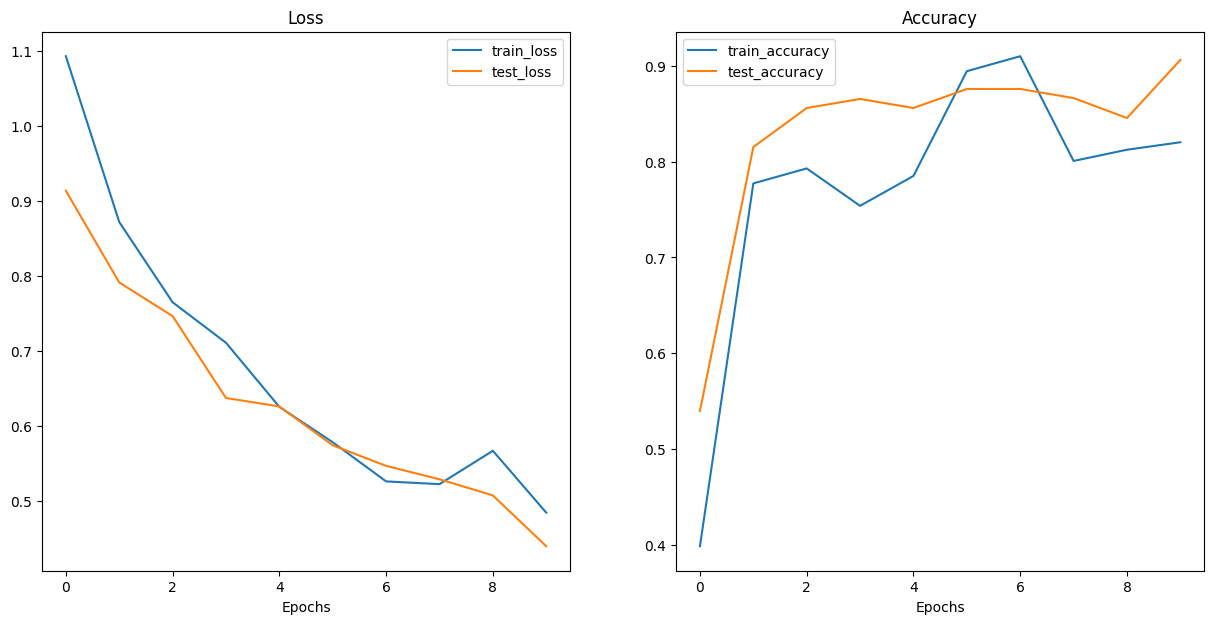

In [ ]:
plot_loss_curves(model_1_results)

# Training the model on a larger dataset

In [ ]:
images_path_new = main_path / 'pizza_steak_sushi_20_percent'
if images_path_new.is_dir():
  print(f'{images_path_new} already exists')
else:
  print(f'{images_path_new} does not exists, creating one...')
  images_path_new.mkdir(parents = True, exist_ok = True)

  with open(main_path / 'pizza_steak_sushi_20_percent.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')
    print(f'Downloading the zip file')
    f.write(request.content)

  with zipfile.ZipFile(main_path / 'pizza_steak_sushi_20_percent.zip', 'r') as zip_file:
    print('Extracting the downloaded zip file')
    zip_file.extractall(images_path_new)

  os.remove(main_path / 'pizza_steak_sushi_20_percent.zip')

data/pizza_steak_sushi_20_percent does not exists, creating one...
Extracting the downloaded zip file


In [ ]:
train_dir_20 = images_path_new / 'train'
test_dir_20 = images_path_new / 'test'
train_dir_20, test_dir_20

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
weights_2 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights_2.transforms()

In [ ]:
train_dataloader_20, test_dataloader_20, class_names_20 = data_setup.create_dataloaders(train_dir = train_dir_20,
                                                                                        test_dir = test_dir_20,
                                                                                        transform = auto_transform,
                                                                                        batch_size = 32,
                                                                                        )

len(train_dataloader_20), len(test_dataloader_20), class_names_20

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
model_2 = torchvision.models.efficientnet_b0(weights = weights_2).to(device)

In [ ]:
for param in model_2.features.parameters():
  param.requires_grad = False

torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

In [ ]:
model_2_summary = summary(model = model_2,
                          input_size = (1,3,224,224),
                          col_names = ['input_size', 'output_size', 'num_params', 'trainable'])
# model_2_summary

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

model_1_new_results = engine.train(model = model_2,
                                   train_dataloader = train_dataloader_20,
                                   test_dataloader = test_dataloader_20,
                                   optimizer = optimizer,
                                   loss_fn = loss_fn,
                                   device = device,
                                   epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9784 | train_acc: 0.5583 | test_loss: 0.6719 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.7148 | train_acc: 0.8167 | test_loss: 0.5588 | test_acc: 0.8727
Epoch: 3 | train_loss: 0.6047 | train_acc: 0.7937 | test_loss: 0.4808 | test_acc: 0.8915
Epoch: 4 | train_loss: 0.4569 | train_acc: 0.9000 | test_loss: 0.4338 | test_acc: 0.8756
Epoch: 5 | train_loss: 0.4566 | train_acc: 0.8812 | test_loss: 0.4090 | test_acc: 0.8858
Epoch: 6 | train_loss: 0.4367 | train_acc: 0.8812 | test_loss: 0.3729 | test_acc: 0.9068
Epoch: 7 | train_loss: 0.4260 | train_acc: 0.8458 | test_loss: 0.3458 | test_acc: 0.9097
Epoch: 8 | train_loss: 0.4209 | train_acc: 0.8479 | test_loss: 0.3594 | test_acc: 0.8642
Epoch: 9 | train_loss: 0.3432 | train_acc: 0.8729 | test_loss: 0.3190 | test_acc: 0.9165
Epoch: 10 | train_loss: 0.3720 | train_acc: 0.8750 | test_loss: 0.3107 | test_acc: 0.8915


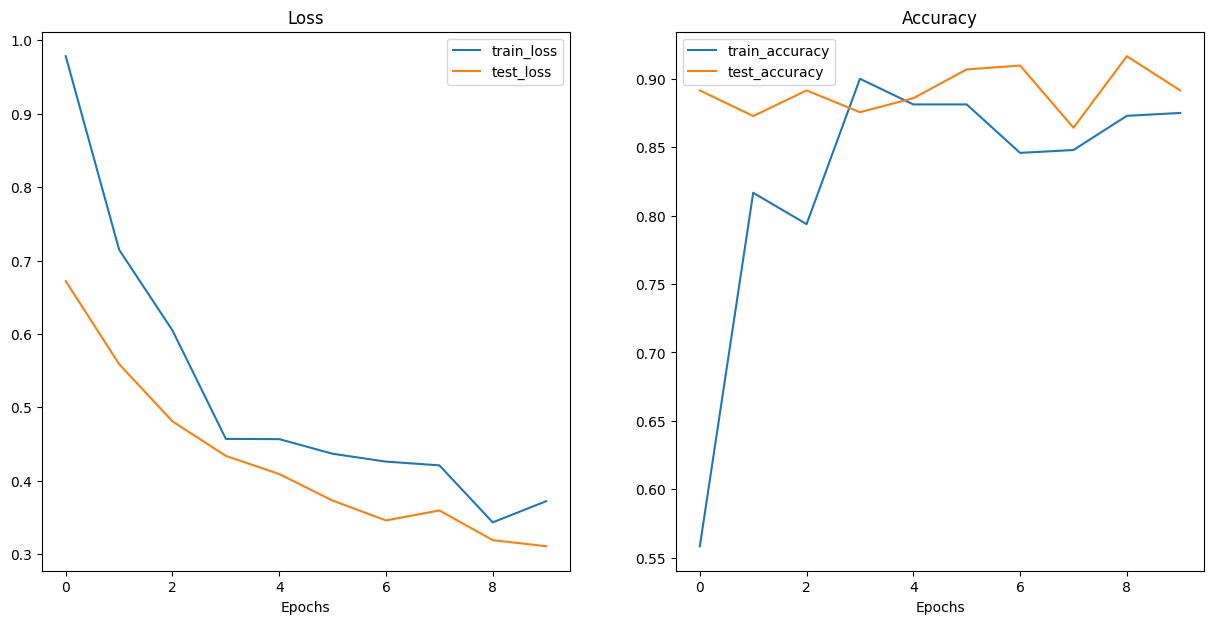

In [ ]:
plot_loss_curves(model_1_new_results)

# Training a new model on the dataset

In [ ]:
weights_new = torchvision.models.EfficientNet_B2_Weights.DEFAULT
new_transform = weights_new.transforms()
model_b2 = torchvision.models.efficientnet_b2(weights = weights_new).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 106MB/s]


In [ ]:
model_b2_summary = summary(model_b2, input_size = (1,3,224,224), col_names = ['input_size', 'output_size','num_params', 'trainable'],
                            col_width = 20, row_settings = ['var_names'])
model_b2_summary

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [ ]:
for param in model_b2.features.parameters():
  param.requires_grad = False

model_b2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [ ]:
train_dataloader_b2, test_dataloader_b2, class_names_b2 = data_setup.create_dataloaders(train_dir = train_dir_20,
                                                                                        test_dir = test_dir_20,
                                                                                        transform = new_transform,
                                                                                        batch_size = 32)

In [ ]:
optimizer = torch.optim.Adam(params = model_b2.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

model_b2_results = engine.train(model = model_b2,
                                train_dataloader = train_dataloader_b2,
                                test_dataloader = test_dataloader_b2,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9750 | train_acc: 0.5938 | test_loss: 0.7498 | test_acc: 0.9131
Epoch: 2 | train_loss: 0.7007 | train_acc: 0.8458 | test_loss: 0.5977 | test_acc: 0.9165
Epoch: 3 | train_loss: 0.5859 | train_acc: 0.8646 | test_loss: 0.4951 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4506 | train_acc: 0.8938 | test_loss: 0.4383 | test_acc: 0.9193
Epoch: 5 | train_loss: 0.4191 | train_acc: 0.9042 | test_loss: 0.4016 | test_acc: 0.9261
Epoch: 6 | train_loss: 0.4275 | train_acc: 0.8979 | test_loss: 0.3563 | test_acc: 0.9534
Epoch: 7 | train_loss: 0.4289 | train_acc: 0.8417 | test_loss: 0.3307 | test_acc: 0.9597
Epoch: 8 | train_loss: 0.3918 | train_acc: 0.8667 | test_loss: 0.3524 | test_acc: 0.9290
Epoch: 9 | train_loss: 0.3772 | train_acc: 0.8854 | test_loss: 0.3174 | test_acc: 0.9227
Epoch: 10 | train_loss: 0.3733 | train_acc: 0.8708 | test_loss: 0.2850 | test_acc: 0.9534
[INFO] Total training time: 63.850153507000016 seconds


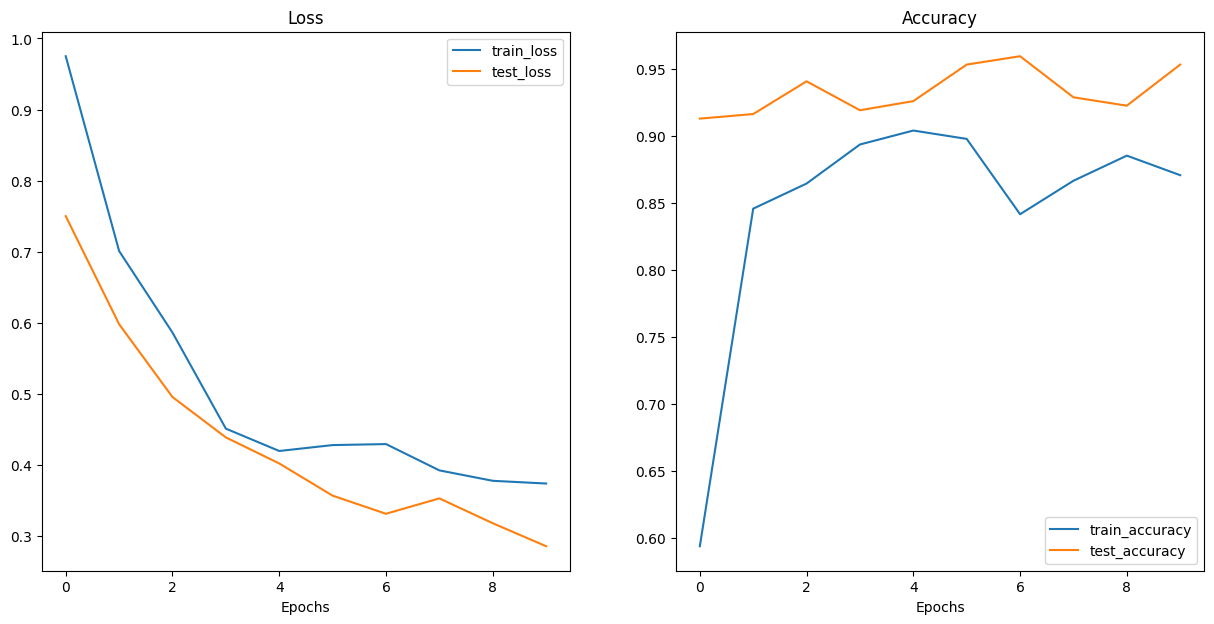

In [ ]:
plot_loss_curves(model_b2_results)